In [1]:
# # UCI HAR - Model Training and Evaluation (with Feature Selection)
#
# This notebook loads the UCI Human Activity Recognition dataset, performs EDA,
# **applies feature selection (removing duplicates and highly correlated features)**,
# preprocesses the selected data (scaling), and then trains and evaluates
# Logistic Regression, Random Forest, and LSTM models on the reduced feature set.

In [2]:
# ## 1. Setup
# Import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import time # To time feature selection


2025-04-01 12:09:03.755683: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-01 12:09:03.767830: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-01 12:09:03.801809: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743489543.853245   55401 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743489543.869318   55401 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743489543.912221   55401 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [3]:
# ## 2. Data Loading
# Load the training and testing datasets. Assuming data is in '../../data/' relative path.

# %%
try:
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
    print("Data loaded successfully.")
    print("Initial Training Data Shape:", train_df.shape)
    print("Initial Testing Data Shape:", test_df.shape)
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure 'train.csv' and 'test.csv' are in the correct directory ")
    # Exit or handle appropriately if data isn't loaded


Data loaded successfully.
Initial Training Data Shape: (7352, 563)
Initial Testing Data Shape: (2947, 563)


In [4]:
 ## 3. Exploratory Data Analysis (EDA)
# Basic exploration of the original dataset.

# %%
print("Training Data Info:")
train_df.info()
print("\nTraining Data Head:")
print(train_df.head())
print("\nMissing values in Training Data:", train_df.isnull().sum().sum())
print("Missing values in Testing Data:", test_df.isnull().sum().sum())
print("\nActivity Distribution:")
print(train_df['Activity'].value_counts())


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 31.6+ MB

Training Data Head:
   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   
2         -0.967187         -0.978944         -0.996520 

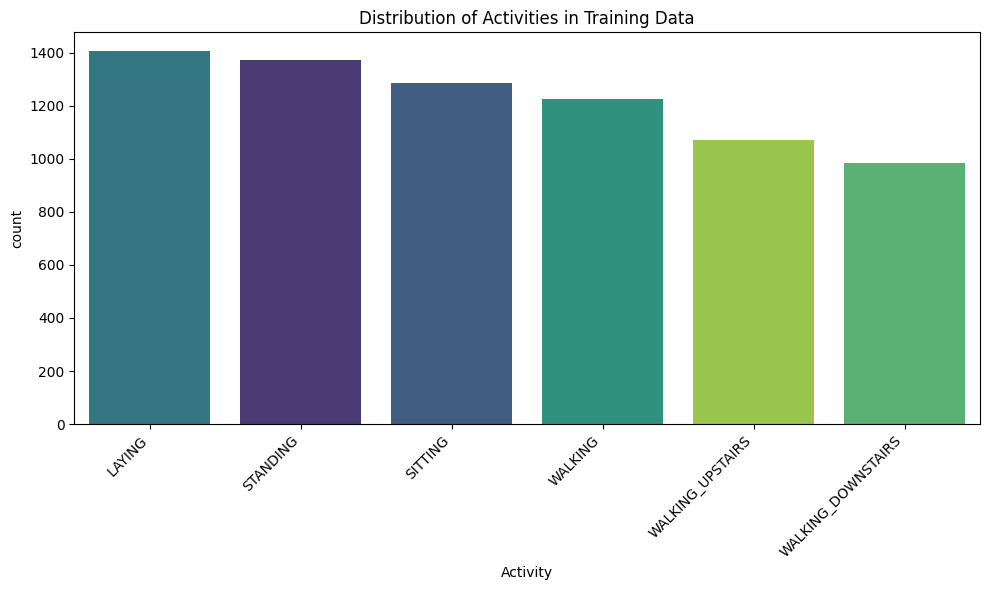

In [5]:
plt.figure(figsize=(10, 6))
sns.countplot(x="Activity", data=train_df, order=train_df['Activity'].value_counts().index, palette="viridis", hue="Activity", dodge=False)
plt.title('Distribution of Activities in Training Data')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

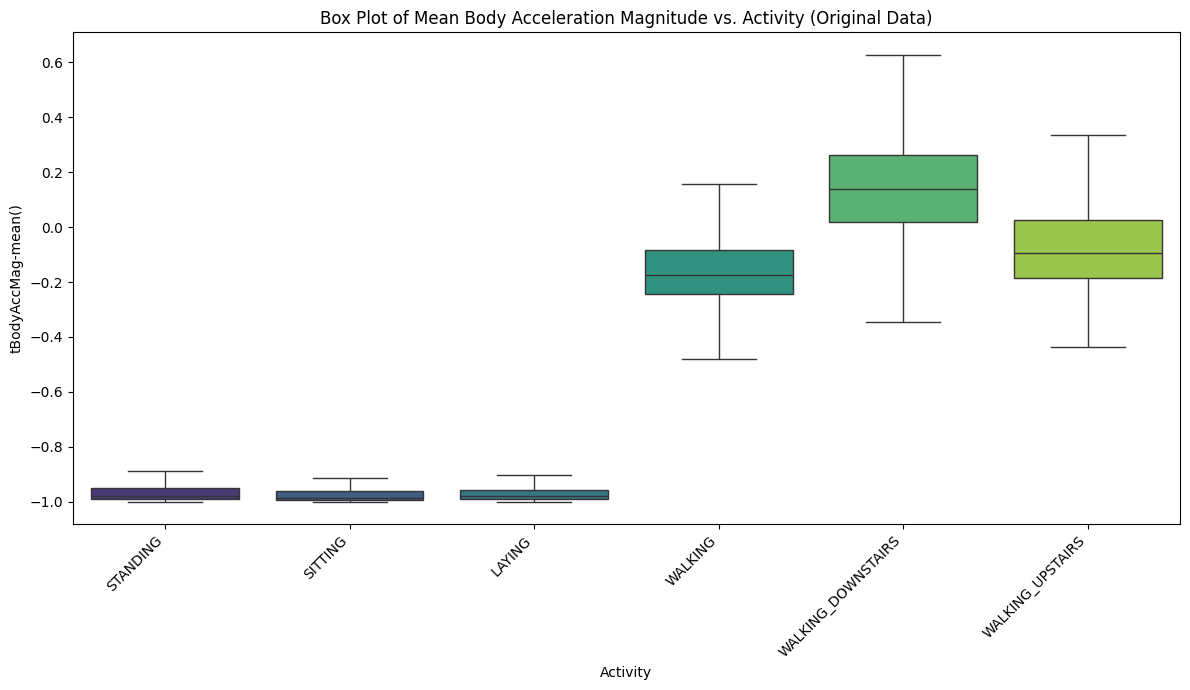

In [6]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Activity', y='tBodyAccMag-mean()', data=train_df, showfliers=False, palette="viridis", hue="Activity", dodge=False, legend=False)
plt.title('Box Plot of Mean Body Acceleration Magnitude vs. Activity (Original Data)')
plt.ylabel('tBodyAccMag-mean()')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

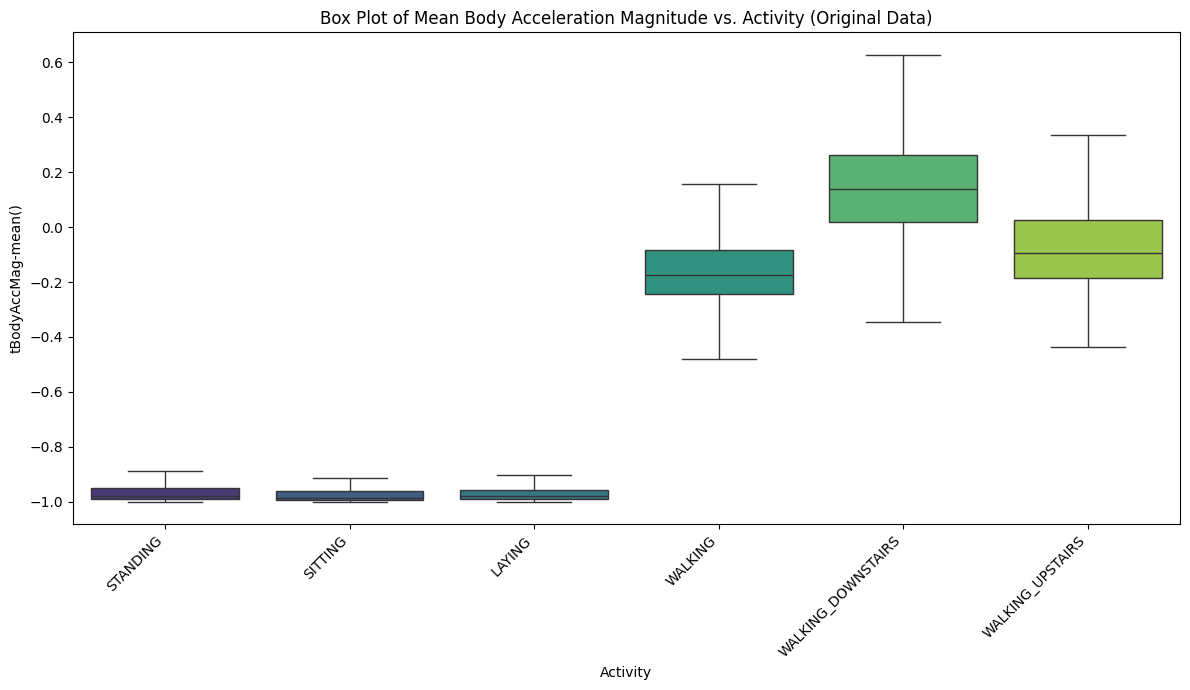

In [7]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Activity', y='tBodyAccMag-mean()', data=train_df, showfliers=False, palette="viridis", hue="Activity", dodge=False, legend=False)
plt.title('Box Plot of Mean Body Acceleration Magnitude vs. Activity (Original Data)')
plt.ylabel('tBodyAccMag-mean()')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [8]:
# ## 4. Feature Selection (NEW POSITION & INTEGRATED)
# Apply feature selection techniques to reduce dimensionality before preprocessing and modeling.

# %%
# Separate features (X) and target (y) from the original dataframes
X_train = train_df.drop('Activity', axis=1)
y_train_labels = train_df['Activity'] # Keep original labels aside for now

X_test = test_df.drop('Activity', axis=1)
y_test_labels = test_df['Activity']   # Keep original labels aside for now

print("--- Starting Feature Selection ---")
print("Original feature count:", X_train.shape[1])
start_time = time.time()

--- Starting Feature Selection ---
Original feature count: 562


In [9]:
# ### 4a. Duplicate Column Removal

# %%
def get_duplicate_columns(df):
    """Identifies duplicate columns in a DataFrame based on content."""
    duplicate_columns = {}
    seen_columns = {}
    for column in df.columns:
        current_column = df[column]
        try:
            # Convert the Series to a hashable type, like a tuple
            current_column_hash = tuple(current_column.values)
        except TypeError:
            try:
                current_column_hash = current_column.values.tobytes()
            except AttributeError:
                 current_column_hash = current_column.to_string().encode()

        if current_column_hash in seen_columns:
            original_column = seen_columns[current_column_hash]
            if original_column not in duplicate_columns:
                duplicate_columns[original_column] = []
            duplicate_columns[original_column].append(column)
        else:
            seen_columns[current_column_hash] = column
    return duplicate_columns

print("\nChecking for duplicate columns...")
duplicate_cols_info = get_duplicate_columns(X_train)
cols_to_drop_duplicates = []
for original, duplicates in duplicate_cols_info.items():
    cols_to_drop_duplicates.extend(duplicates)

print(f"Found {len(cols_to_drop_duplicates)} duplicate columns to remove.")

# Drop duplicates from both X_train and X_test
X_train_no_duplicates = X_train.drop(columns=cols_to_drop_duplicates)
X_test_no_duplicates = X_test.drop(columns=cols_to_drop_duplicates) # Use same columns found in train set
print("Shape after dropping duplicates (Train):", X_train_no_duplicates.shape)
print("Shape after dropping duplicates (Test):", X_test_no_duplicates.shape)



Checking for duplicate columns...
Found 21 duplicate columns to remove.
Shape after dropping duplicates (Train): (7352, 541)
Shape after dropping duplicates (Test): (2947, 541)


In [10]:
# Drop duplicates from both X_train and X_test
X_train_no_duplicates = X_train.drop(columns=cols_to_drop_duplicates)
X_test_no_duplicates = X_test.drop(columns=cols_to_drop_duplicates) # Use same columns found in train set
print("Shape after dropping duplicates (Train):", X_train_no_duplicates.shape)
print("Shape after dropping duplicates (Test):", X_test_no_duplicates.shape)

Shape after dropping duplicates (Train): (7352, 541)
Shape after dropping duplicates (Test): (2947, 541)


In [11]:
# ### 4b. Highly Correlated Feature Removal

# %%
print("\nChecking for highly correlated features...")
# Calculate correlation matrix on training data with duplicates removed
corr_matrix = X_train_no_duplicates.corr().abs()

# Select upper triangle of correlation matrix
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than threshold (e.g., 0.95)
corr_threshold = 0.95
cols_to_drop_correlated = [column for column in upper_tri.columns if any(upper_tri[column] > corr_threshold)]

print(f"Found {len(cols_to_drop_correlated)} highly correlated columns to remove (threshold > {corr_threshold}).")

# Drop highly correlated features from both train and test sets
# Ensure we only drop columns that actually exist in the test set (should be the case if train/test have same initial columns)
cols_to_drop_correlated_in_test = [col for col in cols_to_drop_correlated if col in X_test_no_duplicates.columns]

X_train_selected = X_train_no_duplicates.drop(columns=cols_to_drop_correlated)
X_test_selected = X_test_no_duplicates.drop(columns=cols_to_drop_correlated_in_test)

# Keep track of the final selected columns
final_selected_columns = X_train_selected.columns.tolist()
print("\nFinal selected feature count:", len(final_selected_columns))
print("Shape after dropping highly correlated features (Train):", X_train_selected.shape)
print("Shape after dropping highly correlated features (Test):", X_test_selected.shape)

# Ensure test set has the same columns as the train set after selection
# (This might happen if a column removed based on train correlation didn't exist or was already removed in test)
X_test_selected = X_test_selected[final_selected_columns]
print("Adjusted shape after dropping correlated features (Test):", X_test_selected.shape)


end_time = time.time()
print(f"--- Feature Selection Completed in {end_time - start_time:.2f} seconds ---")


Checking for highly correlated features...
Found 287 highly correlated columns to remove (threshold > 0.95).

Final selected feature count: 254
Shape after dropping highly correlated features (Train): (7352, 254)
Shape after dropping highly correlated features (Test): (2947, 254)
Adjusted shape after dropping correlated features (Test): (2947, 254)
--- Feature Selection Completed in 18.26 seconds ---


In [12]:
# ## 5. Preprocessing on Selected Features (Renumbered)
# Prepare target variable (encode labels) and scale the selected features.

# %%
# Label Encoding the target variable (using the labels kept aside earlier)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_labels)
y_test_encoded = label_encoder.transform(y_test_labels) # Use transform only

activity_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nActivity to Encoded Integer Mapping:")
print(activity_mapping)

# %%
# Feature Scaling (StandardScaler) on the *selected* features
print("\nApplying StandardScaler to selected features...")
scaler = StandardScaler()
# Fit scaler ONLY on the selected training data
X_train_scaled_selected = scaler.fit_transform(X_train_selected)
# Transform the selected test data using the SAME fitted scaler
X_test_scaled_selected = scaler.transform(X_test_selected)

print("Scaled selected X_train shape:", X_train_scaled_selected.shape)
print("Scaled selected X_test shape:", X_test_scaled_selected.shape)
# Note: These are now numpy arrays


Activity to Encoded Integer Mapping:
{'LAYING': np.int64(0), 'SITTING': np.int64(1), 'STANDING': np.int64(2), 'WALKING': np.int64(3), 'WALKING_DOWNSTAIRS': np.int64(4), 'WALKING_UPSTAIRS': np.int64(5)}

Applying StandardScaler to selected features...
Scaled selected X_train shape: (7352, 254)
Scaled selected X_test shape: (2947, 254)



--- Training Logistic Regression Model (Selected Features) ---
Logistic Regression training complete.

--- Evaluating Logistic Regression Model (Selected Features) ---
Test Accuracy (Logistic Regression): 0.9399

Classification Report (Logistic Regression):
                    precision    recall  f1-score   support

            LAYING       1.00      0.98      0.99       537
           SITTING       0.95      0.86      0.90       491
          STANDING       0.87      0.95      0.91       532
           WALKING       0.93      0.98      0.95       496
WALKING_DOWNSTAIRS       0.97      0.94      0.95       420
  WALKING_UPSTAIRS       0.95      0.92      0.93       471

          accuracy                           0.94      2947
         macro avg       0.94      0.94      0.94      2947
      weighted avg       0.94      0.94      0.94      2947


Plotting Confusion Matrix (Logistic Regression)...


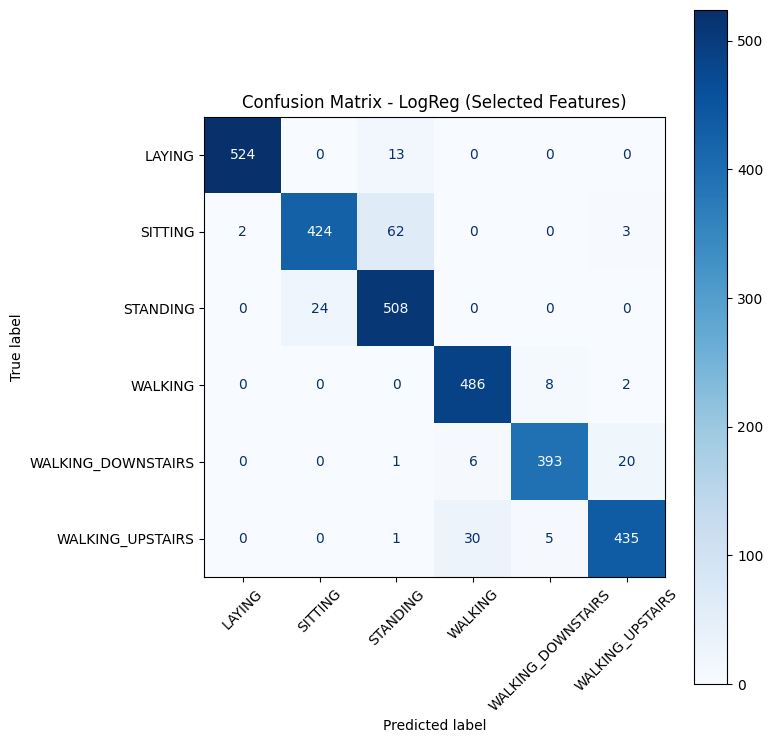

In [13]:
# ## 6. Model Training & Evaluation - Logistic Regression (on Selected Features - Renumbered)

# %%
print("\n--- Training Logistic Regression Model (Selected Features) ---")
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled_selected, y_train_encoded)
print("Logistic Regression training complete.")

# %%
print("\n--- Evaluating Logistic Regression Model (Selected Features) ---")
y_pred_log_reg = log_reg.predict(X_test_scaled_selected)
accuracy_log_reg = accuracy_score(y_test_encoded, y_pred_log_reg)
print(f"Test Accuracy (Logistic Regression): {accuracy_log_reg:.4f}")
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test_encoded, y_pred_log_reg, target_names=label_encoder.classes_))

# %%
print("\nPlotting Confusion Matrix (Logistic Regression)...")
cm_log_reg = confusion_matrix(y_test_encoded, y_pred_log_reg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(8, 8)) # Adjusted size slightly
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)
plt.title('Confusion Matrix - LogReg (Selected Features)')
plt.tight_layout()
plt.show()


--- Training Random Forest Model (Selected Features) ---
Random Forest training complete.

--- Evaluating Random Forest Model (Selected Features) ---
Test Accuracy (Random Forest): 0.9355

Classification Report (Random Forest):
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.95      0.87      0.90       491
          STANDING       0.89      0.95      0.92       532
           WALKING       0.92      0.99      0.95       496
WALKING_DOWNSTAIRS       0.97      0.88      0.92       420
  WALKING_UPSTAIRS       0.90      0.91      0.91       471

          accuracy                           0.94      2947
         macro avg       0.94      0.93      0.93      2947
      weighted avg       0.94      0.94      0.94      2947


Plotting Confusion Matrix (Random Forest)...


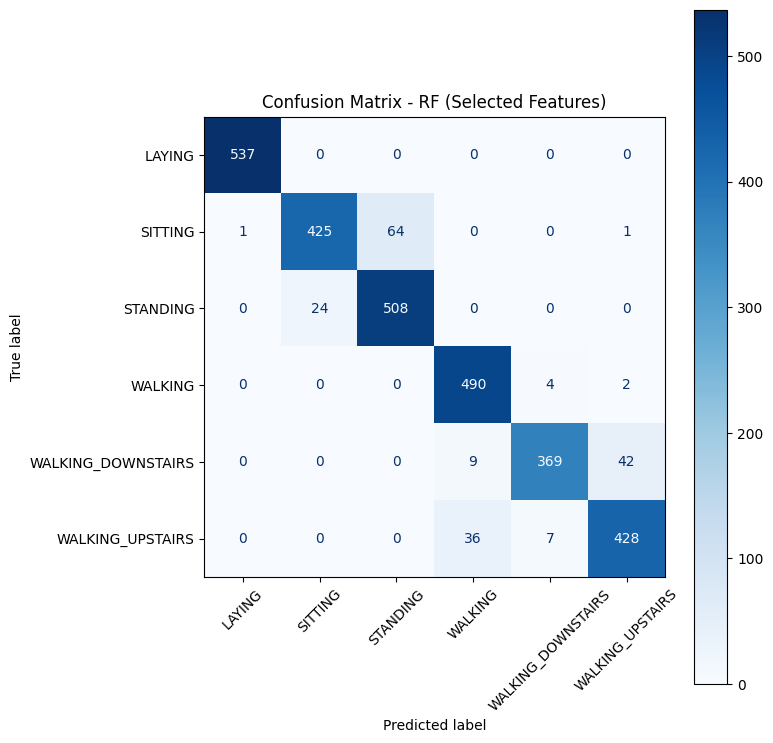

In [14]:
# ## 7. Model Training & Evaluation - Random Forest Classifier (on Selected Features - Renumbered)

# %%
print("\n--- Training Random Forest Model (Selected Features) ---")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=20, min_samples_split=5)
rf_model.fit(X_train_scaled_selected, y_train_encoded)
print("Random Forest training complete.")

# %%
print("\n--- Evaluating Random Forest Model (Selected Features) ---")
y_pred_rf = rf_model.predict(X_test_scaled_selected)
accuracy_rf = accuracy_score(y_test_encoded, y_pred_rf)
print(f"Test Accuracy (Random Forest): {accuracy_rf:.4f}")
print("\nClassification Report (Random Forest):")
print(classification_report(y_test_encoded, y_pred_rf, target_names=label_encoder.classes_))

# %%
print("\nPlotting Confusion Matrix (Random Forest)...")
cm_rf = confusion_matrix(y_test_encoded, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=label_encoder.classes_)
fig_rf, ax_rf = plt.subplots(figsize=(8, 8)) # Adjusted size slightly
disp_rf.plot(cmap=plt.cm.Blues, ax=ax_rf, xticks_rotation=45)
plt.title('Confusion Matrix - RF (Selected Features)')
plt.tight_layout()
plt.show()

# ## 8. Model Training & Evaluation - LSTM (on Selected Features - Renumbered)

In [15]:
# ### 8a. LSTM Data Preparation (Reshaping Selected Features)

# %%
# Get the number of features AFTER selection
n_selected_features = X_train_scaled_selected.shape[1]
print(f"\nNumber of features for LSTM input: {n_selected_features}")

# Reshape the scaled+selected data for LSTM: (n_samples, 1 timestep, n_selected_features)
X_train_reshaped_selected = X_train_scaled_selected.reshape((X_train_scaled_selected.shape[0], 1, n_selected_features))
X_test_reshaped_selected = X_test_scaled_selected.reshape((X_test_scaled_selected.shape[0], 1, n_selected_features))

print("Reshaped selected X_train for LSTM:", X_train_reshaped_selected.shape)
print("Reshaped selected X_test for LSTM:", X_test_reshaped_selected.shape)


Number of features for LSTM input: 254
Reshaped selected X_train for LSTM: (7352, 1, 254)
Reshaped selected X_test for LSTM: (2947, 1, 254)


In [16]:
# ### 8b. LSTM Model Definition and Training (on Selected Features)

# %%
# Define LSTM model building function (remains the same)
def build_lstm_model(input_shape, output_shape):
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, return_sequences=False)) # Adjusted units slightly if needed, return_sequences=False for final LSTM layer
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_shape, activation='softmax')) # output_shape = number of classes
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Define LSTM training function (remains the same)
def train_lstm_model(X_train, Y_train, X_val, Y_val, batch_size=64, epochs=50):
    input_shape = (X_train.shape[1], X_train.shape[2]) # (timesteps, features)
    output_shape = len(np.unique(Y_train)) # Number of unique classes
    model = build_lstm_model(input_shape, output_shape)
    print("\nLSTM Model Summary:")
    model.summary() # Summary will now reflect the reduced input feature count
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    print("\n--- Training LSTM Model (Selected Features) ---")
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val, Y_val), callbacks=[early_stopping], verbose=1)
    print("LSTM training complete.")
    return model, history

# %%
# Train the LSTM model using the reshaped selected+scaled data
lstm_model, lstm_history = train_lstm_model(X_train_reshaped_selected, y_train_encoded,
                                            X_test_reshaped_selected, y_test_encoded) # Using test set as validation

2025-04-01 12:10:00.609774: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/preethi/Work/PGAIML/Capstone/HumanActivityRecognition/DataSets/UCI/archive/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



LSTM Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │       196,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,742 (799.77 KB)

 Trainable params: 204,742 (799.77 KB)

 Non-trainable params: 0 (0.00 B)


--- Training LSTM Model (Selected Features) ---
Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.6519 - loss: 1.0080 - val_accuracy: 0.9192 - val_loss: 0.2198
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9384 - loss: 0.1737 - val_accuracy: 0.9270 - val_loss: 0.1764
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9620 - loss: 0.1030 - val_accuracy: 0.9365 - val_loss: 0.1640
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9723 - loss: 0.0835 - val_accuracy: 0.9464 - val_loss: 0.1517
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9770 - loss: 0.0656 - val_accuracy: 0.9369 - val_loss: 0.1762
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9762 - loss: 0.0575 - val_accuracy: 0.9413 - val_loss: 0.1736
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9839 - loss: 0.0444 - val_accuracy: 0.9352 - val_loss: 0.1899
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/


--- Evaluating LSTM Model (Selected Features) ---


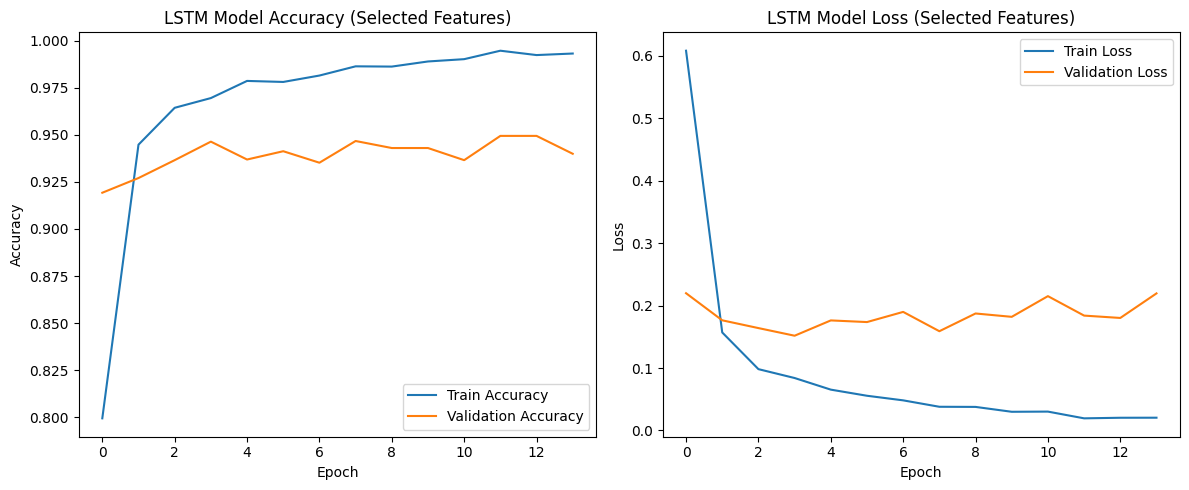


Test Loss (LSTM - Selected Features): 0.1517
Test Accuracy (LSTM - Selected Features): 0.9464
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

Classification Report (LSTM - Selected Features):
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.91      0.92      0.91       491
          STANDING       0.93      0.91      0.92       532
           WALKING       0.94      0.98      0.96       496
WALKING_DOWNSTAIRS       0.96      0.91      0.94       420
  WALKING_UPSTAIRS       0.93      0.94      0.94       471

          accuracy                           0.95      2947
         macro avg       0.95      0.95      0.95      2947
      weighted avg       0.95      0.95      0.95      2947


Plotting Confusion Matrix (LSTM - Selected Features)...


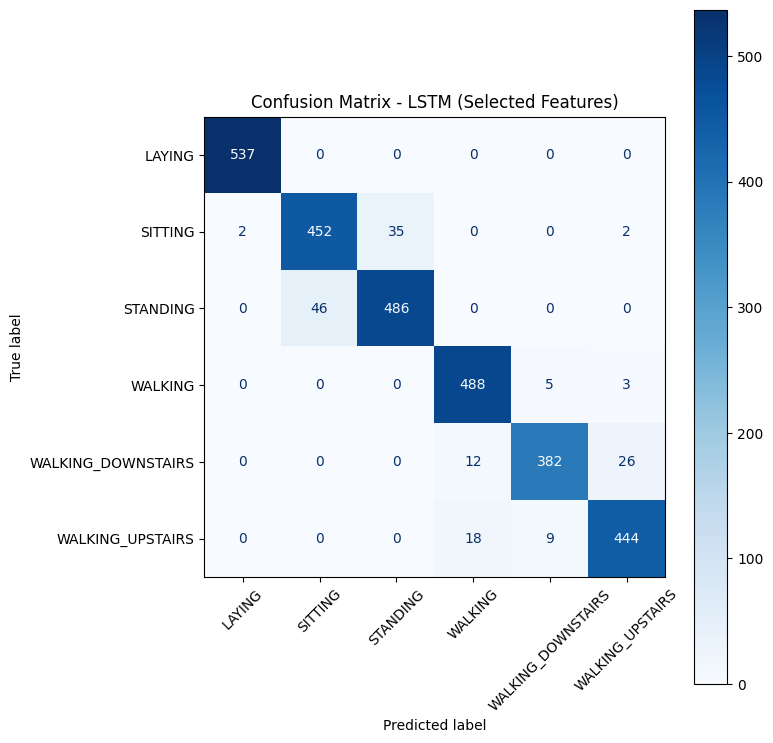

In [17]:
# ### 8c. LSTM Evaluation (on Selected Features)

# %%
print("\n--- Evaluating LSTM Model (Selected Features) ---")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'], label='Train Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy (Selected Features)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'], label='Train Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss (Selected Features)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# %%
loss, accuracy_lstm = lstm_model.evaluate(X_test_reshaped_selected, y_test_encoded, verbose=0)
print(f"\nTest Loss (LSTM - Selected Features): {loss:.4f}")
print(f"Test Accuracy (LSTM - Selected Features): {accuracy_lstm:.4f}")

# %%
y_pred_prob_lstm = lstm_model.predict(X_test_reshaped_selected)
y_pred_lstm = np.argmax(y_pred_prob_lstm, axis=1)
print("\nClassification Report (LSTM - Selected Features):")
print(classification_report(y_test_encoded, y_pred_lstm, target_names=label_encoder.classes_))

# %%
print("\nPlotting Confusion Matrix (LSTM - Selected Features)...")
cm_lstm = confusion_matrix(y_test_encoded, y_pred_lstm)
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm, display_labels=label_encoder.classes_)
fig_lstm, ax_lstm = plt.subplots(figsize=(8, 8)) # Adjusted size slightly
disp_lstm.plot(cmap=plt.cm.Blues, ax=ax_lstm, xticks_rotation=45)
plt.title('Confusion Matrix - LSTM (Selected Features)')
plt.tight_layout()
plt.show()

In [18]:
# ## 9. Model Saving (Placeholder - Renumbered)
#
# We will add code here to save the chosen model (`log_reg`, `rf_model`, or `lstm_model`)
# **which has been trained on the feature-selected data**, and its associated
# preprocessors (`label_encoder`, `scaler` **fitted on selected data**, and the list of `final_selected_columns`).

# %%
print("\n--- Code Execution Complete with Integrated Feature Selection ---")
print("Models trained on feature-selected data: LogReg (`log_reg`), RF (`rf_model`), LSTM (`lstm_model`)")
# Also important to save: `label_encoder`, `scaler`, `final_selected_columns`
print("Next step: Decide which model to save for Streamlit deployment.")


--- Code Execution Complete with Integrated Feature Selection ---
Models trained on feature-selected data: LogReg (`log_reg`), RF (`rf_model`), LSTM (`lstm_model`)
Next step: Decide which model to save for Streamlit deployment.


In [20]:
# %% [markdown]
# ## 8.5 Select and Save Predefined Samples (NEW SECTION)
# Select one sample row from the feature-selected test data for each activity
# These will be used in the Streamlit app for demonstration.

# %%
print("\n--- Selecting Predefined Samples for Streamlit ---")

# Ensure we have the original labels and the feature-selected data
# y_test_labels (original string labels for test set)
# X_test_selected (DataFrame with selected features, before scaling)

predefined_samples = {}
unique_activities = sorted(y_test_labels.unique()) # Get sorted list of unique activity names

for activity in unique_activities:
    # Find the index of the first occurrence of this activity in the test labels
    try:
        # Get the first index where the condition is true
        sample_index = y_test_labels[y_test_labels == activity].index[0]

        # Select the corresponding row from the feature-selected test data (as a numpy array)
        # Ensure X_test_selected is a DataFrame here
        sample_data = X_test_selected.loc[sample_index].values.reshape(1, -1) # Reshape to 2D (1, n_features)

        # Store it in the dictionary with a descriptive key
        sample_key = f"Sample: {activity}"
        predefined_samples[sample_key] = sample_data
        print(f"Selected sample for '{activity}' at index {sample_index}")

    except IndexError:
        print(f"Warning: Could not find any samples for activity '{activity}' in the test set.")


# Check if we found samples
if not predefined_samples:
    print("Error: No predefined samples were selected. Cannot save samples file.")
else:
    # --- Add this saving step to the *EXISTING* saving section (Section 9) ---
    # (Or save it here if you prefer, just ensure it's saved)

    # Example of adding it within Section 9 (inside the artifacts_dir logic):
    predefined_samples_path = os.path.join(artifacts_dir, "predefined_samples.joblib")
    joblib.dump(predefined_samples, predefined_samples_path)
    print(f"\nPredefined samples dictionary saved to: {predefined_samples_path}")

# Make sure you adjust the final print statement in section 9 if you place the saving code there.


--- Selecting Predefined Samples for Streamlit ---
Selected sample for 'LAYING' at index 55
Selected sample for 'SITTING' at index 31
Selected sample for 'STANDING' at index 0
Selected sample for 'WALKING' at index 79
Selected sample for 'WALKING_DOWNSTAIRS' at index 109
Selected sample for 'WALKING_UPSTAIRS' at index 133

Predefined samples dictionary saved to: saved_artifacts/predefined_samples.joblib


In [ ]:

# ## 9. Model and Preprocessor Saving (Updated)
# Save all three trained models and the necessary preprocessors/metadata
# required for the Streamlit application.

# %%
import os
import joblib

# Define directory to save artifacts
artifacts_dir = "saved_artifacts"
os.makedirs(artifacts_dir, exist_ok=True) # Create directory if it doesn't exist
print(f"Artifacts will be saved in: {artifacts_dir}")

# --- Save Scikit-learn Models and Objects using joblib ---

# 1. Save Logistic Regression Model
log_reg_path = os.path.join(artifacts_dir, "log_reg_model.joblib")
joblib.dump(log_reg, log_reg_path)
print(f"Logistic Regression model saved to: {log_reg_path}")

# 2. Save Random Forest Model
rf_model_path = os.path.join(artifacts_dir, "rf_model.joblib")
joblib.dump(rf_model, rf_model_path)
print(f"Random Forest model saved to: {rf_model_path}")

# 3. Save the Label Encoder
label_encoder_path = os.path.join(artifacts_dir, "label_encoder.joblib")
joblib.dump(label_encoder, label_encoder_path)
print(f"Label Encoder saved to: {label_encoder_path}")

# 4. Save the Scaler
scaler_path = os.path.join(artifacts_dir, "scaler.joblib")
joblib.dump(scaler, scaler_path)
print(f"StandardScaler saved to: {scaler_path}")

# 5. Save the list of final selected columns
final_columns_path = os.path.join(artifacts_dir, "final_columns.joblib")
joblib.dump(final_selected_columns, final_columns_path)
print(f"List of selected columns saved to: {final_columns_path}")


# --- Save TensorFlow/Keras Model ---

# 6. Save LSTM Model (using .h5 format for simplicity)
lstm_model_path = os.path.join(artifacts_dir, "lstm_model.h5")
lstm_model.save(lstm_model_path)
print(f"LSTM model saved to: {lstm_model_path}")
print(f"\nPredefined samples dictionary saved to: {predefined_samples_path}")
print("\n--- All Models and Preprocessors Saved Successfully ---")

Artifacts will be saved in: saved_artifacts
Logistic Regression model saved to: saved_artifacts/log_reg_model.joblib
Random Forest model saved to: saved_artifacts/rf_model.joblib
Label Encoder saved to: saved_artifacts/label_encoder.joblib


StandardScaler saved to: saved_artifacts/scaler.joblib
List of selected columns saved to: saved_artifacts/final_columns.joblib
LSTM model saved to: saved_artifacts/lstm_model.h5

--- All Models and Preprocessors Saved Successfully ---
